<p style="text-align:center">\n
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">\n
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">\n
    </a>\n
</p>\n

# **Classification-based Rating Mode Prediction using Embedding Features**

Estimated time needed: **60** minutes

We turn rating prediction into a **classification** task by combining user and item embeddings into a single feature vector **X** and predicting categorical rating labels **y**.

## Objectives

After completing this lab you will be able to:

* Build classification models to predict rating modes from combined embeddings
* Compare aggregation strategies (sum / product / concatenation)
* Tune models with GridSearchCV and log artifacts/plots to your repo structure

----
## Prepare and setup lab environment

In [1]:
%pip install -q scikit-learn pandas matplotlib joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, json
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# random seed
rs = 123
np.random.seed(rs)

### Project paths (repo-aware)

In [3]:
CWD = Path.cwd().resolve()
if CWD.name == 'notebooks' and (CWD.parent / 'data').exists():
    PROJECT_ROOT = CWD.parent
elif (CWD / 'data').exists():
    PROJECT_ROOT = CWD
else:
    PROJECT_ROOT = CWD

DATA_DIR = PROJECT_ROOT / 'data'
EXTERNAL_DIR = DATA_DIR / 'external'
PROCESSED_DIR = DATA_DIR / 'processed'
REPORTS_FIG_DIR = PROJECT_ROOT / 'reports' / 'figures'
LOGS_DIR = PROJECT_ROOT / 'logs'
MODELS_DIR = PROJECT_ROOT / 'models'

for d in [EXTERNAL_DIR, PROCESSED_DIR, REPORTS_FIG_DIR, LOGS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('PROJECT_ROOT:', PROJECT_ROOT)

PROJECT_ROOT: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone


## Load datasets (local first, remote fallback)

In [4]:
# ratings
rating_local = EXTERNAL_DIR / 'course_ratings.csv'
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df = pd.read_csv(rating_local) if rating_local.exists() else pd.read_csv(rating_url)
rating_df = rating_df[['user','item','rating']].copy()

# embeddings (prefer ones exported by your CF neural net; else hosted)
user_emb_local = PROCESSED_DIR / 'user_embeddings_baseline.csv'
item_emb_local = PROCESSED_DIR / 'item_embeddings_baseline.csv'
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

user_emb_raw = pd.read_csv(user_emb_local) if user_emb_local.exists() else pd.read_csv(user_emb_url)
item_emb_raw = pd.read_csv(item_emb_local) if item_emb_local.exists() else pd.read_csv(item_emb_url)

print('ratings:', rating_df.shape, '| user_emb:', user_emb_raw.shape, '| item_emb:', item_emb_raw.shape)
rating_df.head(3)

ratings: (233306, 3) | user_emb: (33901, 17) | item_emb: (126, 17)


,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5


### Normalize embedding column names

We enforce:
- User id column: `user`; user features: `UFeature0..`
- Item id column: `item`; item features: `CFeature0..`

In [5]:
def normalize_user_emb(df):
    df = df.copy()
    id_col = 'user' if 'user' in df.columns else ('user_id' if 'user_id' in df.columns else None)
    assert id_col is not None, 'User embedding must include user or user_id column'
    feat_cols = [c for c in df.columns if c != id_col]
    rename_map = {id_col: 'user'}
    for i, c in enumerate(feat_cols):
        rename_map[c] = f'UFeature{i}'
    out = df.rename(columns=rename_map)
    return out, [f'UFeature{i}' for i in range(len(feat_cols))]

def normalize_item_emb(df):
    df = df.copy()
    id_col = 'item' if 'item' in df.columns else ('item_id' if 'item_id' in df.columns else None)
    assert id_col is not None, 'Item embedding must include item or item_id column'
    feat_cols = [c for c in df.columns if c != id_col]
    rename_map = {id_col: 'item'}
    for i, c in enumerate(feat_cols):
        rename_map[c] = f'CFeature{i}'
    out = df.rename(columns=rename_map)
    return out, [f'CFeature{i}' for i in range(len(feat_cols))]

user_emb, u_features = normalize_user_emb(user_emb_raw)
item_emb, c_features = normalize_item_emb(item_emb_raw)

print(len(u_features), 'user features |', len(c_features), 'item features')
display(user_emb.head(2))
display(item_emb.head(2))

16 user features | 16 item features


,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.033022,0.068657,0.004409,0.003708,0.064142,-0.034011,-0.027975,-0.002681,0.015392,-0.074402,0.020501,0.046947,0.067408,-0.027664,0.025213,-0.055095
1,1342067,-0.009976,-0.019721,-0.006740,0.005201,-0.032104,0.029420,0.030979,0.029344,-0.000229,-0.021921,-0.007147,-0.000556,-0.000393,-0.009939,-0.014357,0.021424


,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,-0.172086,-0.033214,0.107699,0.231775,0.008553,-0.325155,0.177375,-0.036309,0.127059,0.129681,-0.134265,0.119908,0.119611,0.111782,-0.280107,-0.041800
1,CL0101EN,-0.037116,0.177518,-0.004479,0.133399,0.072230,0.015994,-0.054191,-0.181337,0.088625,0.157015,-0.133860,0.055236,-0.148096,-0.042896,0.122026,-0.078289


### Merge embeddings into the rating rows

In [6]:
merged = rating_df.merge(user_emb, on='user', how='left').merge(item_emb, on='item', how='left')
merged = merged.fillna(0)
print(merged.shape)
merged.head(3)

(233306, 35)


,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,5,0.033022,0.068657,0.004409,0.003708,0.064142,-0.034011,-0.027975,...,0.177375,-0.036309,0.127059,0.129681,-0.134265,0.119908,0.119611,0.111782,-0.280107,-0.041800
1,1342067,CL0101EN,3,-0.009976,-0.019721,-0.006740,0.005201,-0.032104,0.029420,0.030979,...,-0.054191,-0.181337,0.088625,0.157015,-0.133860,0.055236,-0.148096,-0.042896,0.122026,-0.078289
2,1990814,ML0120ENv3,5,-0.078293,0.022187,0.010924,0.002994,0.018679,-0.044196,0.033823,...,-0.130364,0.094914,-0.096233,0.002598,-0.029295,0.035682,-0.102239,-0.131291,0.090083,-0.058062


### Build classification datasets (aggregation strategies)

We prepare three feature sets:

- **sum**: element-wise add (size = k)
- **prod**: element-wise product (size = k)
- **concat**: concatenation (size = 2k)

In [7]:
U = merged[u_features].values.astype('float32')
C = merged[c_features].values.astype('float32')
y_raw = merged['rating'].values  # categorical labels

if U.shape[1] != C.shape[1]:
    print('Warning: user/item embedding dims differ; sum/prod disabled. Using concat only.')
    X_sets = {'concat': np.concatenate([U, C], axis=1)}
else:
    X_sets = {
        'sum': U + C,
        'prod': U * C,
        'concat': np.concatenate([U, C], axis=1)
    }

# Encode ratings as categorical classes (LabelEncoder keeps a reversible mapping)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
classes = list(label_encoder.classes_)
n_classes = len(classes)
print('Classes:', classes)

def stratified_split(X, y, test_size=0.2, rs=rs):
    return train_test_split(X, y, test_size=test_size, random_state=rs, stratify=y)

Xy_splits = {}
for name, X in X_sets.items():
    X_train, X_test, y_train, y_test = stratified_split(X, y)
    Xy_splits[name] = (X_train, X_test, y_train, y_test)
    print(f"{name} → X: {X.shape}, y: {y.shape}")

Classes: [np.int64(3), np.int64(4), np.int64(5)]
sum → X: (233306, 16), y: (233306,)
prod → X: (233306, 16), y: (233306,)
concat → X: (233306, 32), y: (233306,)


## Train & evaluate models (with tuning)

We compare:
- **Logistic Regression** (multinomial)
- **SVC** (RBF)
- **RandomForest**
- **GradientBoosting**

We use **GridSearchCV (cv=3)** with **macro F1** to handle class imbalance.

In [8]:
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision_macro': prec, 'recall_macro': rec, 'f1_macro': f1}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

results = []
best_estimators = {}  # (agg, model) -> estimator

for agg_name, (X_train, X_test, y_train, y_test) in Xy_splits.items():
    # Baseline: predict most frequent class in TRAIN
    values, counts = np.unique(y_train, return_counts=True)
    majority = values[np.argmax(counts)]
    yhat = np.full_like(y_test, fill_value=majority)
    base_metrics = evaluate(y_test, yhat)
    base_row = {'agg': agg_name, 'model': 'BaselineMajority', **base_metrics, 'best_params': {}}
    results.append(base_row)

    # 1) Logistic Regression (standardize)
    logreg = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('clf', LogisticRegression(multi_class='auto', max_iter=200, random_state=rs))
    ])
    grid_lr = { 'clf__C': [0.1, 1.0, 3.0, 10.0] }
    gs_lr = GridSearchCV(logreg, grid_lr, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs_lr.fit(X_train, y_train)
    yhat = gs_lr.predict(X_test)
    m = evaluate(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'LogisticRegression', **m, 'best_params': gs_lr.best_params_})
    best_estimators[(agg_name, 'LogisticRegression')] = gs_lr.best_estimator_

    # 2) SVC (standardize)
    svc = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=False, random_state=rs))
    ])
    grid_svc = { 'clf__C': [0.5, 1.0, 3.0], 'clf__gamma': ['scale', 0.1, 0.01] }
    gs_svc = GridSearchCV(svc, grid_svc, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs_svc.fit(X_train, y_train)
    yhat = gs_svc.predict(X_test)
    m = evaluate(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'SVC', **m, 'best_params': gs_svc.best_params_})
    best_estimators[(agg_name, 'SVC')] = gs_svc.best_estimator_

    # 3) RandomForest (no scaling)
    rf = RandomForestClassifier(random_state=rs, n_jobs=-1)
    grid_rf = { 'n_estimators': [150, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5] }
    gs_rf = GridSearchCV(rf, grid_rf, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs_rf.fit(X_train, y_train)
    yhat = gs_rf.predict(X_test)
    m = evaluate(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'RandomForest', **m, 'best_params': gs_rf.best_params_})
    best_estimators[(agg_name, 'RandomForest')] = gs_rf.best_estimator_

    # 4) GradientBoosting (no scaling)
    gb = GradientBoostingClassifier(random_state=rs)
    grid_gb = { 'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [2, 3] }
    gs_gb = GridSearchCV(gb, grid_gb, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs_gb.fit(X_train, y_train)
    yhat = gs_gb.predict(X_test)
    m = evaluate(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'GradientBoosting', **m, 'best_params': gs_gb.best_params_})
    best_estimators[(agg_name, 'GradientBoosting')] = gs_gb.best_estimator_

results_df = pd.DataFrame(results).sort_values(['agg','f1_macro'], ascending=[True, False]).reset_index(drop=True)
results_df

### Save metrics table

In [9]:
metrics_csv = PROCESSED_DIR / 'classification_results.csv'
results_df.to_csv(metrics_csv, index=False)
print('Saved:', metrics_csv)

Saved: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/classification_results.csv


### Pick best model overall (by F1 macro) and evaluate deeper

In [10]:
best_row = results_df.loc[results_df['f1_macro'].idxmax()].to_dict()
best_row

{'agg': 'concat',
 'model': 'SVC',
 'accuracy': 0.6785178517851785,
 'precision_macro': 0.6896186577777872,
 'recall_macro': 0.6785437477317231,
 'f1_macro': 0.6819940187845943,
 'best_params': {'clf__C': 1.0, 'clf__gamma': 'scale'}}

In [11]:
best_agg = best_row['agg']
best_model_name = best_row['model']
X_train, X_test, y_train, y_test = Xy_splits[best_agg]
best_est = best_estimators[(best_agg, best_model_name)]

y_pred = best_est.predict(X_test)
report = classification_report(y_test, y_pred, target_names=[str(c) for c in classes], zero_division=0)
print(report)

              precision    recall  f1-score   support

           3       0.75      0.70      0.72     15573
           4       0.56      0.65      0.60     15588
           5       0.76      0.69      0.72     15501

    accuracy                           0.68     46662
   macro avg       0.69      0.68      0.68     46662
weighted avg       0.69      0.68      0.68     46662



### Confusion matrix (best model)

Saved confusion matrix to: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/reports/figures/confusion_matrix_concat_SVC.png


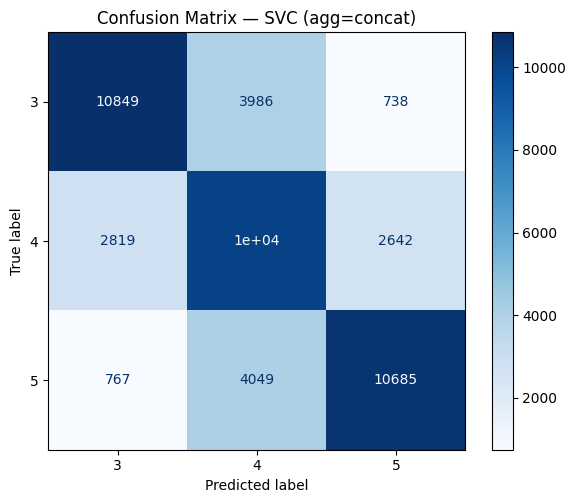

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[str(c) for c in classes], cmap='Blues', ax=ax)
plt.title(f'Confusion Matrix — {best_model_name} (agg={best_agg})')
plt.tight_layout()
cm_path = REPORTS_FIG_DIR / f'confusion_matrix_{best_agg}_{best_model_name}.png'
plt.savefig(cm_path, dpi=150)
print('Saved confusion matrix to:', cm_path)
plt.show()

### Save best model + metadata

In [15]:
model_path = MODELS_DIR / f'best_cls_model_{best_agg}_{best_model_name}.joblib'
joblib.dump(best_est, model_path)

meta = {
  'timestamp': datetime.utcnow().isoformat() + 'Z',
  'task': 'rating_classification',
  'best': best_row,
  'classes': classes,
  'label_encoder_classes_': list(label_encoder.classes_),
  'aggregation': best_agg,
  'model_path': str(model_path)
}
meta_path = LOGS_DIR / 'classification_experiment_meta.json'
with open(meta_path, 'w') as f: json.dump(meta, f, indent=2,
          default=lambda o: o.item() if isinstance(o, np.generic)
          else (o.tolist() if isinstance(o, np.ndarray) else str(o)))
print('Saved best model/meta to:', model_path, '|', meta_path)

Saved best model/meta to: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/models/best_cls_model_concat_SVC.joblib | /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/logs/classification_experiment_meta.json


/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_78936/2069489370.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat() + 'Z',


## Optional: Inspect linear model coefficients

If the best model is Logistic Regression, we export the top positive/negative weights per class.

In [14]:
if best_model_name == 'LogisticRegression':
    pipe = best_est
    clf = pipe.named_steps['clf'] if isinstance(best_est, Pipeline) else best_est
    # Build feature names for chosen agg
    kU = len(u_features); kC = len(c_features)
    if best_agg == 'concat':
        feat_names = [f'UFeature{i}' for i in range(kU)] + [f'CFeature{i}' for i in range(kC)]
    elif best_agg == 'sum':
        k = min(kU, kC)
        feat_names = [f'SumFeature{i}' for i in range(k)]
    else:
        k = min(kU, kC)
        feat_names = [f'ProdFeature{i}' for i in range(k)]

    coefs = pd.DataFrame(clf.coef_, columns=feat_names)
    coef_csv = PROCESSED_DIR / f'coefficients_{best_agg}_LogisticRegression.csv'
    coefs.to_csv(coef_csv, index=False)
    print('Saved coefficients to:', coef_csv)
else:
    print('Best model is not LogisticRegression — skipping coefficient export.')

Best model is not LogisticRegression — skipping coefficient export.


## Summary

In this lab you:

- Normalized and merged **user**/**item** embeddings with rating rows
- Built **sum/product/concat** feature sets
- Trained **LogisticRegression / SVC / RandomForest / GradientBoosting** with **GridSearchCV**
- Evaluated using **accuracy** and **macro precision/recall/F1**
- Saved artifacts: 
  - Metrics: `data/processed/classification_results.csv`
  - Best model: `models/best_cls_model_*.joblib`
  - Confusion matrix: `reports/figures/confusion_matrix_*.png`
  - Run metadata: `logs/classification_experiment_meta.json`
- (Optional) Exported coefficients for Logistic Regression

## Authors

[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)

### Change Log

|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-10-25|1.0|Yan|Created the initial version|
|2025-10-05|1.1|You|Completed TODOs, added multi-aggregation, tuning, evaluation, and artifact logging|

Copyright © 2021–2025 IBM Corporation. All rights reserved.